In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn import preprocessing

In [3]:
table_nm = 'DLAB_INTERN_TR_IFO_TMP' 
names = ['iqr_dt','cus_no','act_no','mkt_gb','pdt_gb','iem_cd','iem_krl_anm','bnc_qty','tot_aet_amt'] 
file_path = f'/home/sbx/data/DATA0113/DATA/AGE1030/{table_nm}_1030.csv' 
df_trd_1 = pd.read_csv(file_path)

table_nm = 'DLAB_INTERN_TR_IFO_TMP' 
names = ['iqr_dt','cus_no','act_no','mkt_gb','pdt_gb','iem_cd','iem_krl_anm','bnc_qty','tot_aet_amt'] 
file_path = f'/home/sbx/data/DATA0113/DATA/AGE1030/{table_nm}2_1030.csv' 
df_trd_2 = pd.read_csv(file_path) 

table_nm = 'DLAB_HT_L1_CUS_IFO_TMP' 
names = ['cus_no','sex_dit_cd','cus_age','zip_ctp_cd', 'tco_cus_grd_cd', 'ivs_icn_cd'] 
file_path = f'/home/sbx/data/DATA0113/DATA/AGE1030/{table_nm}_1030.csv' 
df_cus = pd.read_csv(file_path) 

table_nm = 'DLAB_HT_L1_ACT_IFO_TMP' 
names = ['act_no','cus_no','act_opn_ym'] 
file_path = f'/home/sbx/data/DATA0113/DATA/AGE1030/{table_nm}_1030.csv' 
df_act = pd.read_csv(file_path) 

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
df_trd = pd.merge(left=df_trd_1, right=df_trd_2[df_trd_2['iqr_dt'] > 20210701], how='outer')

In [8]:
df_act = df_act.drop('Unnamed: 0', axis=1)
df_cus = df_cus.drop('Unnamed: 0', axis=1)
df_trd = df_trd.drop('Unnamed: 0', axis=1)

In [135]:
#choose 440 customers with trd data & remove 이상한 데이터 (customers with US25459W4583)
df_cus_w = df_cus.copy()[(df_cus['cus_no'].isin(df_trd['cus_no'])) 
                         & ~(df_cus['cus_no'].isin(df_trd[(df_trd['iem_cd'] == "US25459W4583")]['cus_no']))
                        & (df_cus['cus_age'] < 28)]

In [136]:
df_bal = df_trd.copy()[['iqr_dt', 'cus_no', 'tot_aet_amt']].groupby(['iqr_dt', 'cus_no']).sum()
df_bal = df_bal.reset_index()
df_bal_kor = df_trd[df_trd['mkt_gb'] == '국내'].copy()[['iqr_dt', 'cus_no', 'tot_aet_amt']].groupby(['iqr_dt', 'cus_no']).sum()
df_bal_kor = df_bal_kor.reset_index()
df_bal_ovs = df_trd[df_trd['mkt_gb'] == '해외'].copy()[['iqr_dt', 'cus_no', 'tot_aet_amt']].groupby(['iqr_dt', 'cus_no']).sum()
df_bal_ovs = df_bal_ovs.reset_index()

In [137]:
df_bal_tot = pd.merge(left=df_bal, 
                      right=df_bal_kor[['iqr_dt','cus_no', 'tot_aet_amt']], 
                      on=['cus_no', 'iqr_dt'], 
                      suffixes=('', '_kr'), 
                      how='left')
df_bal_tot = pd.merge(left=df_bal_tot, 
                      right=df_bal_ovs[['iqr_dt','cus_no', 'tot_aet_amt']], 
                      on=['cus_no', 'iqr_dt'], 
                      suffixes=('', '_ov'), 
                      how='left')

In [138]:
df_bal_tot[['tot_aet_amt_kr', 'tot_aet_amt_ov']] = df_bal_tot[['tot_aet_amt_kr', 'tot_aet_amt_ov']].fillna(0)

In [139]:
df_bal_list = []
df_bal_len = []
for i in df_bal_tot['iqr_dt'].unique():
    df = df_bal_tot[df_bal_tot['iqr_dt'] == i]
    df = pd.merge(left=df_cus_w, right=df, on='cus_no', suffixes=('','')) #if how='left', customers who haven't opened an account appear
    df['ovs_ratio'] = df['tot_aet_amt_ov'] / df['tot_aet_amt']
    df_bal_list.append(df)
    df_bal_len.append(len(df))

In [140]:
df_bal_list[0].head()

,cus_no,sex_dit_cd,cus_age,zip_ctp_cd,tco_cus_grd_cd,ivs_icn_cd,iqr_dt,tot_aet_amt,tot_aet_amt_kr,tot_aet_amt_ov,ovs_ratio
0,102997409,2,27,11,09,04,20210101,42150,42150.0,0.0,0.0
1,103067802,2,25,26,09,04,20210101,2574500,2574500.0,0.0,0.0
2,102525304,1,27,41,05,03,20210101,3801200,3801200.0,0.0,0.0
3,102655907,1,17,11,05,03,20210101,21314100,21314100.0,0.0,0.0
4,101634349,1,27,45,09,-,20210101,2238870,2238870.0,0.0,0.0


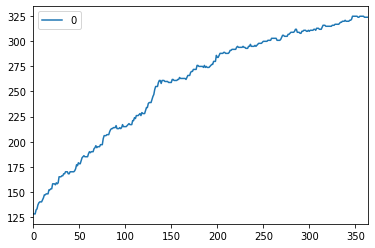

In [141]:
pd.DataFrame(df_bal_len).plot()

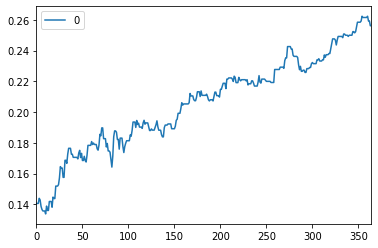

In [142]:
ovs_pct = []
for i in range(365):
    df = df_bal_list[i]
    ovs_pct.append(len(df[df['ovs_ratio'] > 0])/len(df))
pd.DataFrame(ovs_pct).plot() #고객 중 해외주식 보유자 비중 변화

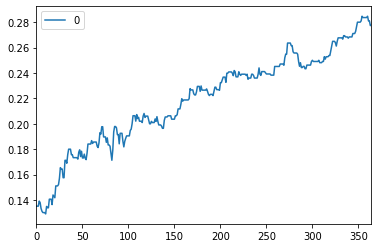

In [143]:
ovs_pct = []
for i in range(365):
    df = df_bal_list[i][df_bal_list[i]['cus_age'] > 19]
    ovs_pct.append(len(df[df['ovs_ratio'] > 0])/len(df))
pd.DataFrame(ovs_pct).plot() #20대 고객 중 해외주식 보유자 비중 변화

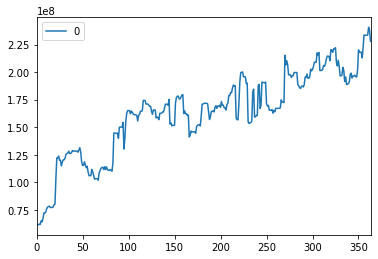

In [149]:
#해외주식 보유액 변화
ovs_tot_amt = []
for i in range(365):
    df = df_bal_list[i]
    ovs_tot_amt.append(df['tot_aet_amt_ov'].sum())
pd.DataFrame(ovs_tot_amt).plot()

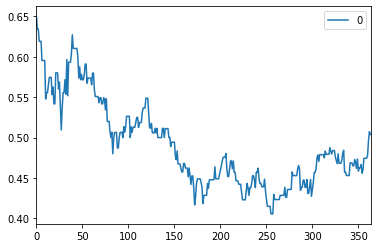

In [53]:
#해외주식을 보유하고 있는 고객 중 해외주식이 자산 비중의 50% 이상인 고객 비율 변화
ovs_avg_ratio = []
for i in range(365):
    df = df_bal_list[i]
    df_hlf = df[df['ovs_ratio'] > 0.5]
    df_ovs = df[df['ovs_ratio'] > 0]
    ovs_avg_ratio.append(len(df_hlf)/len(df_ovs))
pd.DataFrame(ovs_avg_ratio).plot()

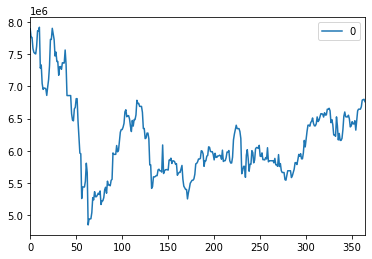

In [44]:
#해외주식을 보유하고 있는 고객 중 해외주식 평가액 평균 변화
ovs_avg_ratio = []
for i in range(365):
    df = df_bal_list[i]
    df_ovs = df[df['ovs_ratio'] > 0]
    ovs_avg_ratio.append(df_ovs['tot_aet_amt_ov'].mean())
pd.DataFrame(ovs_avg_ratio).plot()

In [34]:
df_bal_list_10_19 = []
df_bal_list_20_24 = []
df_bal_list_25_30 = []
for i in range(len(df_bal_list)):
    df_bal_list_10_19.append(df_bal_list[i][(df_bal_list[i]['cus_age'] > 9) & (df_bal_list[i]['cus_age'] < 20)])
    df_bal_list_20_24.append(df_bal_list[i][(df_bal_list[i]['cus_age'] > 19) & (df_bal_list[i]['cus_age'] < 25)])
    df_bal_list_25_30.append(df_bal_list[i][(df_bal_list[i]['cus_age'] > 24) & (df_bal_list[i]['cus_age'] < 31)])

60

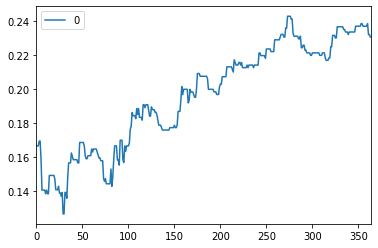

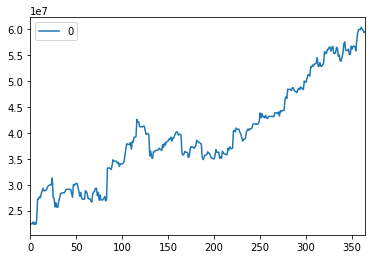

In [36]:
#20대 초반 투자자 해외투자 비중 변화
#20대 초반 투자자 해외투자액 변화

df_list = df_bal_list_20_24
num_ppl = []
ovs_pct = []
ovs_pct_ratio = []
ovs_avg_ratio = []
ovs_tot_amt = []
for i in range(365):
    df = df_list[i]
    df_hlf = df[df['ovs_ratio'] > 0.5]
    df_ovs = df[df['ovs_ratio'] > 0]
    ovs_pct.append(len(df[df['ovs_ratio'] > 0])/len(df))
    ovs_pct_ratio.append(len(df_hlf)/len(df_ovs))
    ovs_avg_ratio.append(df_ovs['ovs_ratio'].mean())
    ovs_tot_amt.append(df['tot_aet_amt_ov'].sum())
pd.DataFrame(ovs_pct).plot()
pd.DataFrame(ovs_tot_amt).plot()
len(df_list[1])

127

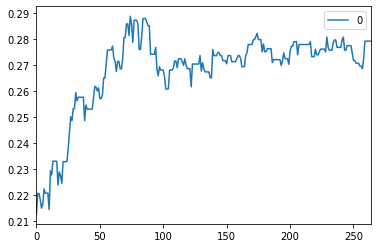

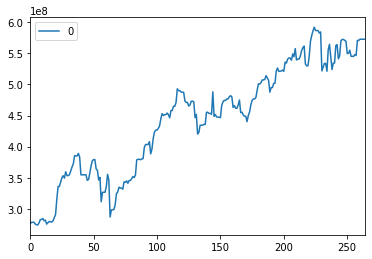

In [39]:
#20대 후반 투자자 해외투자 비율 변화
#20대 후반 투자자 해외투자액 변화

df_list = df_bal_list_25_30

ovs_pct = []
ovs_pct_ratio = []
ovs_avg_ratio = []
ovs_tot_amt = []
for i in range(265):
    df = df_list[i]
    df_hlf = df[df['ovs_ratio'] > 0.5]
    df_ovs = df[df['ovs_ratio'] > 0]
    ovs_pct.append(len(df[df['ovs_ratio'] > 0])/len(df))
    ovs_pct_ratio.append(len(df_hlf)/len(df_ovs))
    ovs_avg_ratio.append(df_ovs['ovs_ratio'].mean())
    ovs_tot_amt.append(df['tot_aet_amt_ov'].sum())
pd.DataFrame(ovs_pct).plot()
pd.DataFrame(ovs_tot_amt).plot()
len(df_list[1])

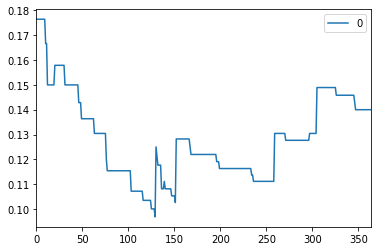

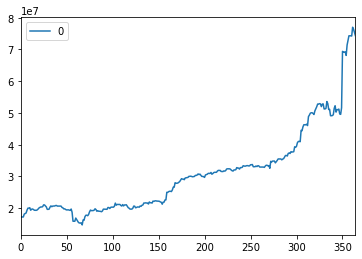

In [38]:
#10대 투자자 해외투자비율 변화
#10대 투자자 해외투자액 변화
df_list = df_bal_list_10_19

ovs_pct = []
ovs_pct_ratio = []
ovs_avg_ratio = []
ovs_tot_amt = []
for i in range(365):
    df = df_list[i]
    df_hlf = df[df['ovs_ratio'] > 0.5]
    df_ovs = df[df['ovs_ratio'] > 0]
    ovs_pct.append(len(df[df['ovs_ratio'] > 0])/len(df))
    ovs_pct_ratio.append(len(df_hlf)/len(df_ovs))
    ovs_avg_ratio.append(df_ovs['ovs_ratio'].mean())
    ovs_tot_amt.append(df['tot_aet_amt_ov'].sum())
pd.DataFrame(ovs_pct).plot()
pd.DataFrame(ovs_tot_amt).plot()

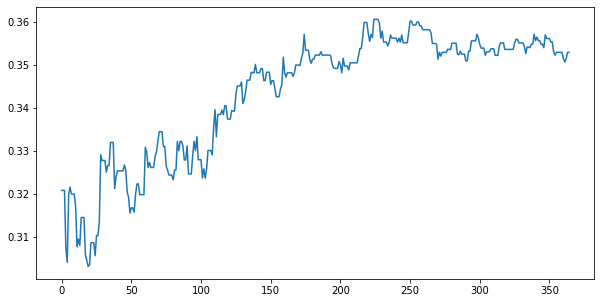

In [151]:
#20대 투자자 중 20대초반의 투자자 비율 변화
plt.figure(figsize=(10, 5))
df_20_24_ratio = []
for i in range(len(df_bal_list)):
    df_20_24_ratio.append(len(df_bal_list_20_24[i])/(len(df_bal_list_25_30[i])+len(df_bal_list_20_24[i])))
plt.plot(pd.DataFrame(df_20_24_ratio))

In [58]:
df_trd_bf = df_trd.copy()[(df_trd['iqr_dt'] < 20210415) & (df_trd['iem_krl_anm'] == '카카오')]
df_trd_af = df_trd.copy()[(df_trd['iqr_dt'] > 20210415) & (df_trd['iem_krl_anm'] == '카카오')]

In [65]:
df_trd_kk = df_trd.copy()[df_trd['iem_krl_anm'] == '카카오']

In [102]:
kk = []
for i in df_trd_kk.groupby('iqr_dt').sum().index:
    #kk.append(df_trd_kk.groupby('iqr_dt')['cus_no'].count()[i])
    kk.append(df_trd_kk.groupby('iqr_dt').sum()['tot_aet_amt'][i])
    if (len(kk) > 180):
        break

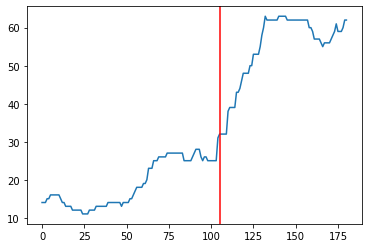

In [96]:
plt.plot(kk)
plt.axvline(x=105, color='r')

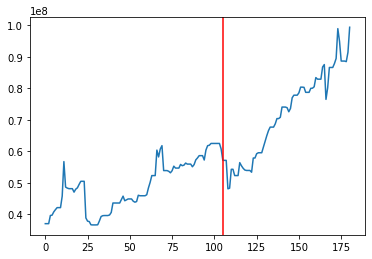

In [103]:
plt.plot(kk)
plt.axvline(x=105, color='r')

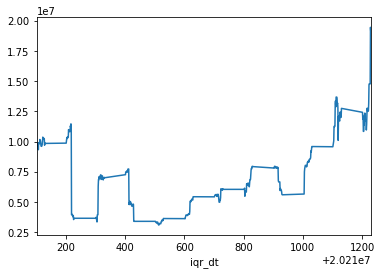

In [111]:
df_trd[df_trd['iem_krl_anm'] == '엔비디아'][['iqr_dt','bnc_qty', 'tot_aet_amt']].astype(int).groupby('iqr_dt').sum()['tot_aet_amt'].plot()